<a href="https://colab.research.google.com/github/B4ben-69/tensorFlow_edging/blob/main/plot_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyWavelets==1.4.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.8 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib==3.7.1

In [2]:
import pywt
import json
import pandas as pd

# Load data from JSON, ignoring lines with "wifiStatus"
with open('/content/drive/MyDrive/Colab Notebooks/stream_output_20240902_085854.txt', 'r') as f:
  data = []
  for line in f:
    try:
      item = json.loads(line)
      if 'pressure' in item:  # Assuming your relevant data has "pressure" key
        data.append(item)
    except json.JSONDecodeError:
      pass  # Ignore lines that are not valid JSON

# Now you have a list of dictionaries with relevant data
# Extract pressure values
pressure_values = [item['pressure'] for item in data]

In [ ]:
pressure_values

In [ ]:

# You can then proceed with the wavelet transform as before

# Perform wavelet transform
coeffs = pywt.wavedec(pressure_values, 'db4', level=5)
#coeffs = pywt.wavedec(pressure_values, 'sym5', level=5)

# 'db4' is the wavelet family, you can experiment with others
# level is the decomposition level

# Access the approximation and detail coefficients
cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

# You can then use these coefficients as features for your neural network

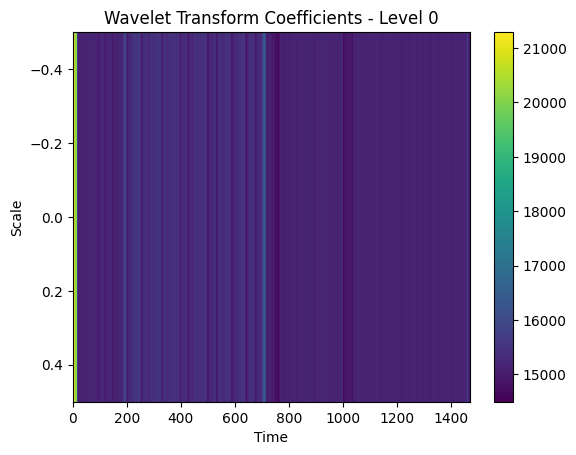

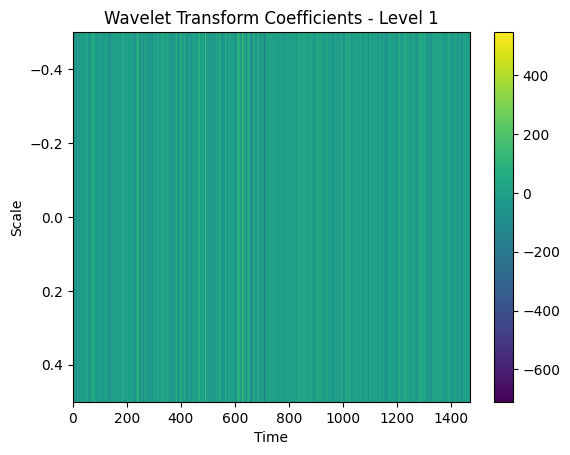

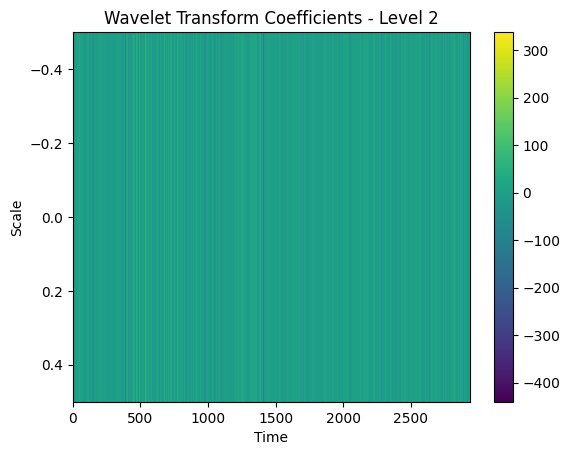

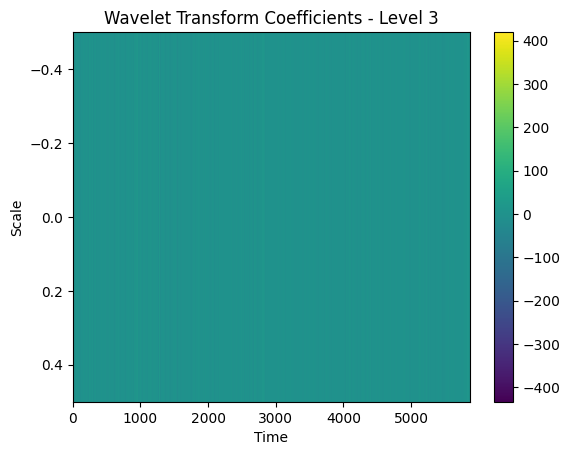

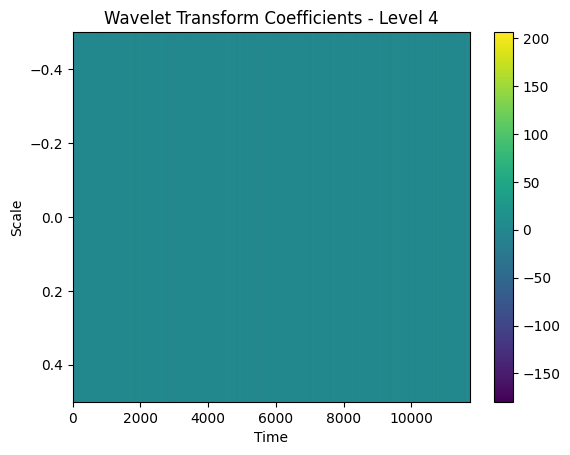

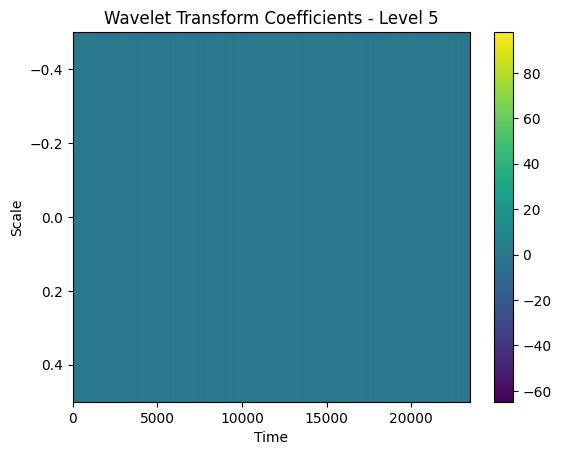

In [ ]:
import matplotlib.pyplot as plt
import pywt

# Assuming 'coeffs' is your list of wavelet coefficients
# obtained from pywt.wavedec

# Plot each set of coefficients separately
for i, coeff in enumerate(coeffs):
    plt.figure()  # Create a new figure for each coefficient array
    plt.imshow([coeff], cmap='viridis', aspect='auto')  # Plot as a 2D array
    plt.title(f'Wavelet Transform Coefficients - Level {i}')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.colorbar()
    plt.show()

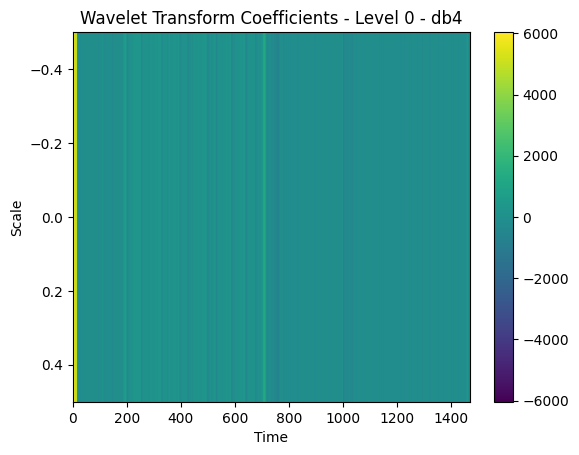

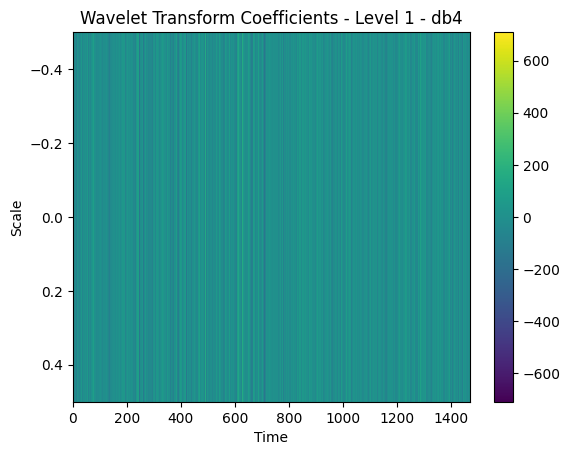

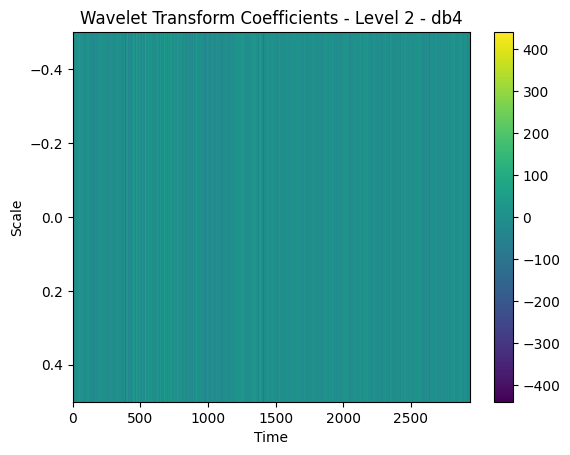

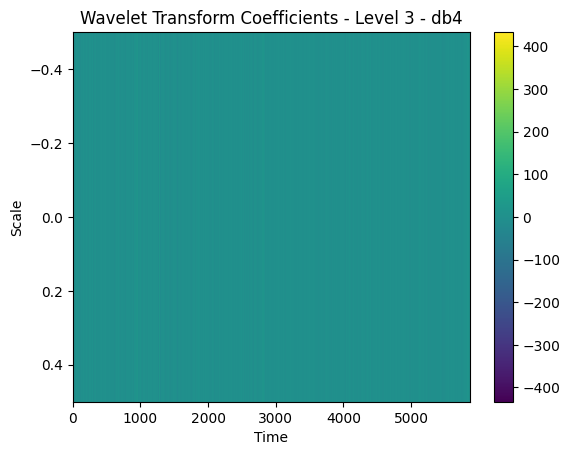

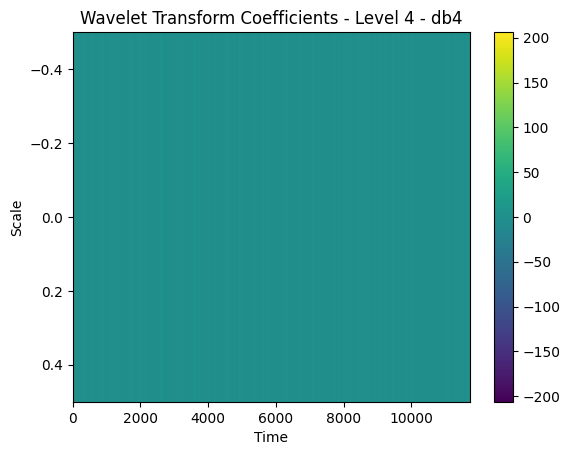

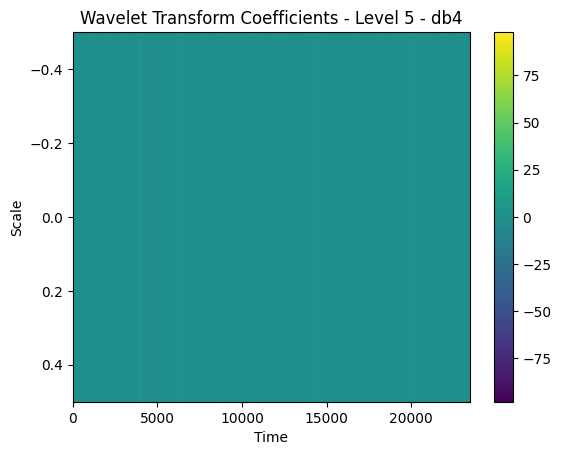

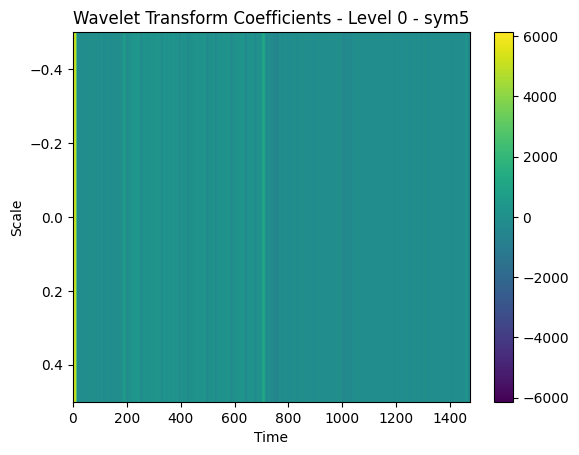

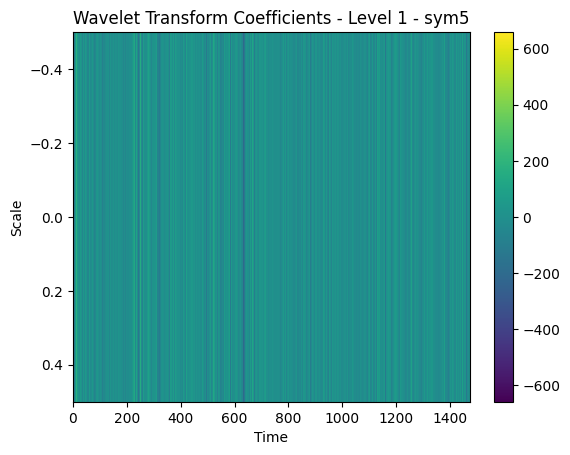

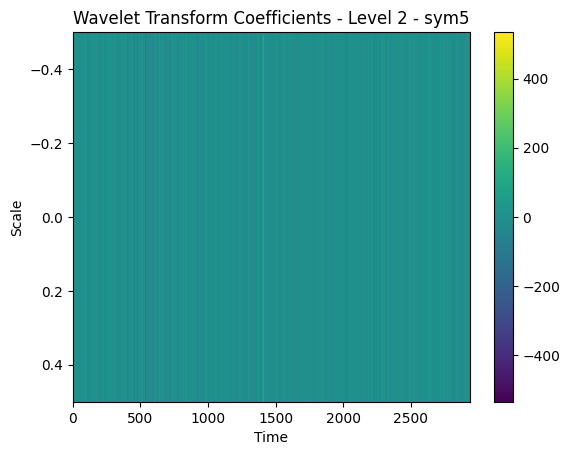

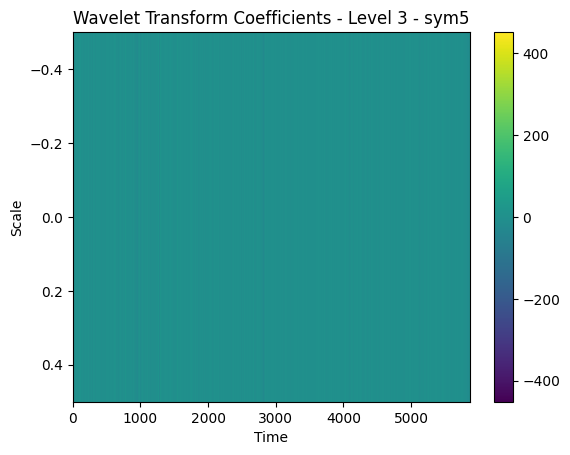

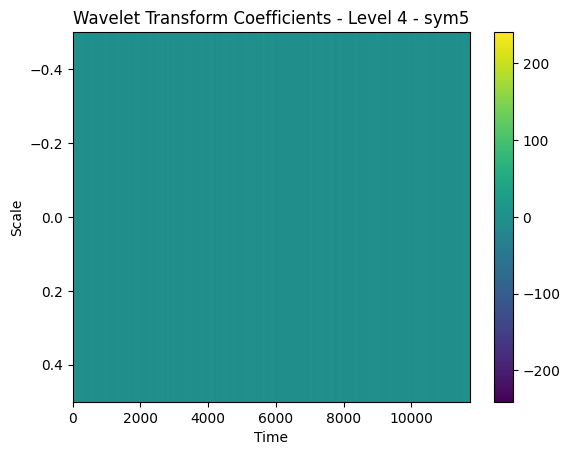

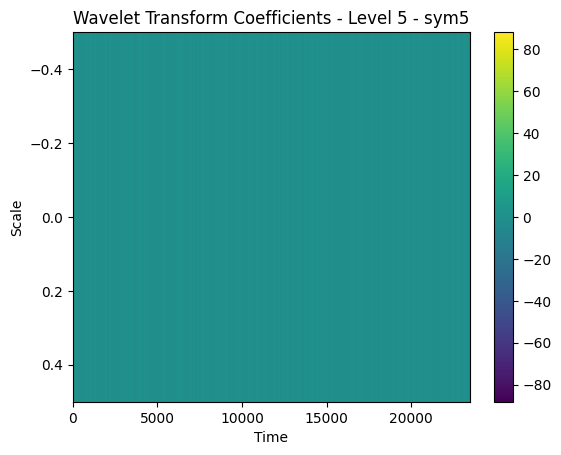

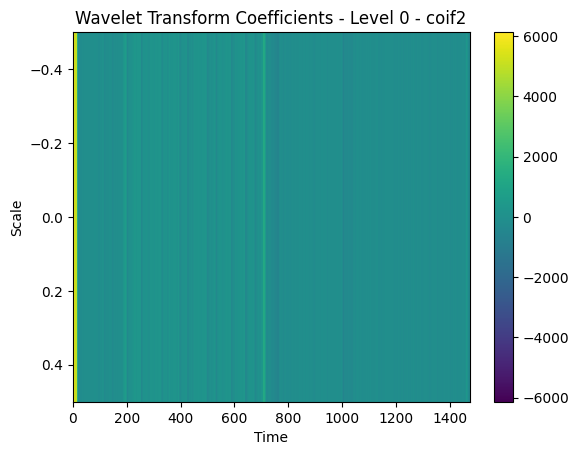

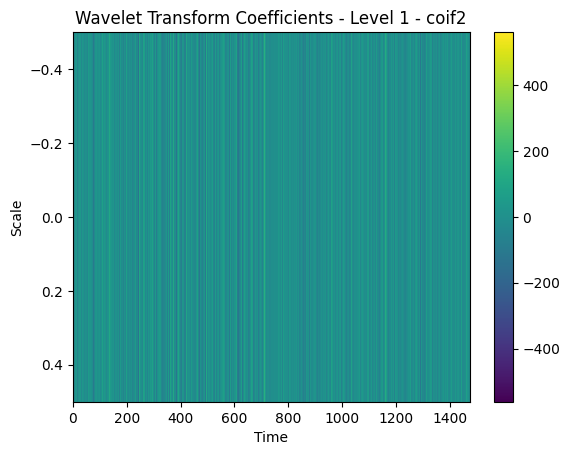

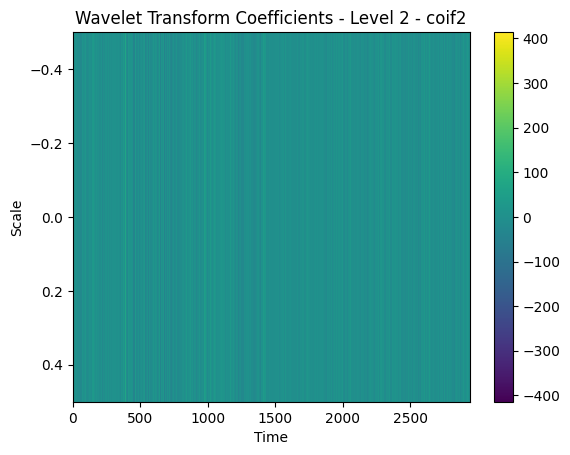

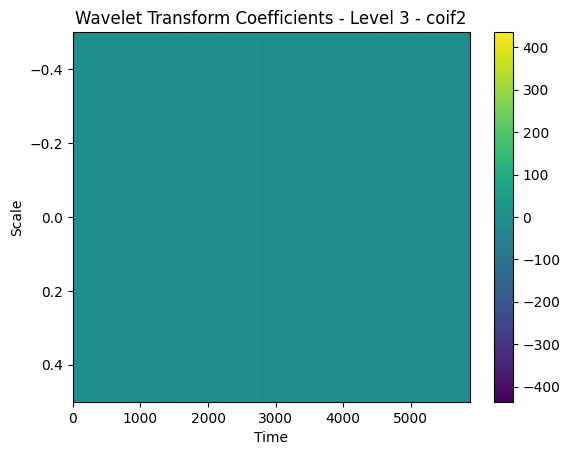

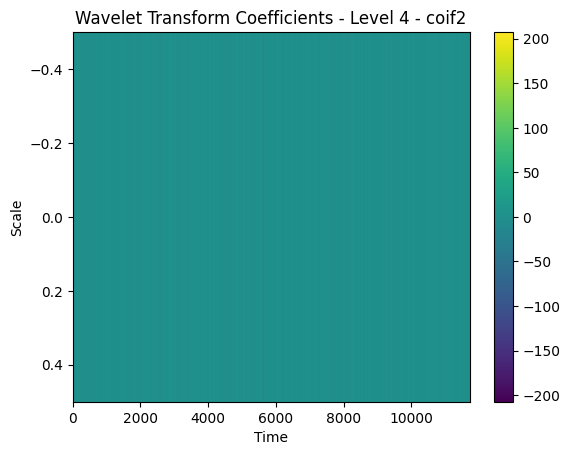

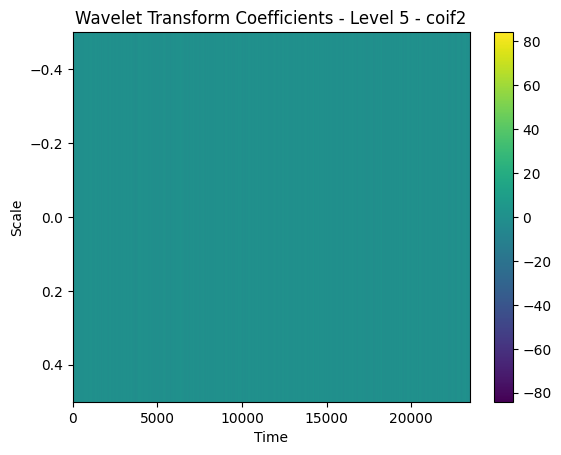

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pressure_values' is your time-series data

# Normalize the data
pressure_values_normalized = pressure_values - np.mean(pressure_values)

# Experiment with different wavelet families
wavelet_families = ['db4', 'sym5', 'coif2']
#wavelet_families = ['db4', 'haar']

for wavelet_family in wavelet_families:
    # Perform wavelet transform
    coeffs = pywt.wavedec(pressure_values_normalized, wavelet_family, level=5)

    # Plot each set of coefficients separately
    for i, coeff in enumerate(coeffs):
        plt.figure()
        plt.imshow([coeff], cmap='viridis', aspect='auto', vmin=-np.max(np.abs(coeff)), vmax=np.max(np.abs(coeff)))
        plt.title(f'Wavelet Transform Coefficients - Level {i} - {wavelet_family}')
        plt.xlabel('Time')
        plt.ylabel('Scale')
        plt.colorbar()
        plt.show()

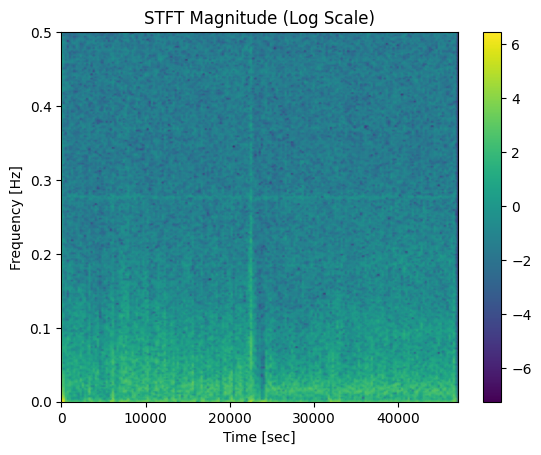

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import stft
import numpy as np

# Assuming 'pressure_values' is your time-series data

# Normalize the data
pressure_values_normalized = pressure_values - np.mean(pressure_values)

# Calculate STFT with a larger window size (e.g., 512)
frequencies, times, Zxx = stft(pressure_values_normalized, nperseg=512)

# Calculate the magnitude of Zxx
Zxx_magnitude = np.abs(Zxx)

# Apply logarithmic scale
Zxx_magnitude_log = np.log(Zxx_magnitude + 1e-10)  # Add a small value to avoid log(0)

# Plot the spectrogram using the log magnitude
plt.pcolormesh(times, frequencies, Zxx_magnitude_log, shading='gouraud')
plt.title('STFT Magnitude (Log Scale)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

Let's explore the Empirical Mode Decomposition (EMD). EMD is a powerful technique for analyzing non-linear and non-stationary signals, which might be suitable for your pressure data if it has complex variations.

Here's how you can use the emd library in Python to perform EMD and visualize the results:


In [ ]:
!pip install emd

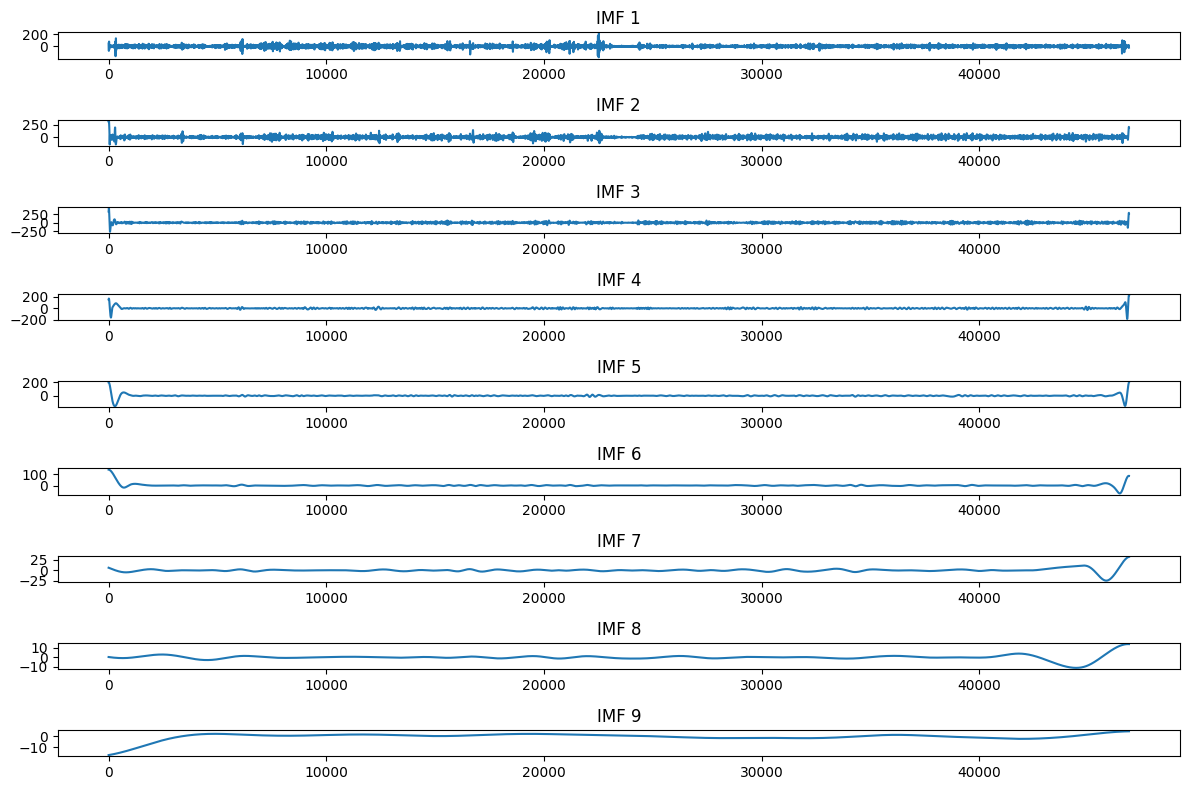

In [10]:
import emd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'pressure_values' is your time-series data

window_size = 100  # Adjust as needed
moving_avg = np.convolve(pressure_values, np.ones(window_size), 'same') / window_size # Changed mode to 'same'
pressure_values_normalized = pressure_values - moving_avg

# Create an EMD object
# Convert 'pressure_values' to a NumPy array
#imf = emd.sift.sift(np.array(pressure_values))
#imf = emd.sift.sift(np.array(pressure_values_normalized))

# Extract the IMFs
imfs = imf[:, 1:]

# Plot the IMFs
num_imfs = imfs.shape[1]
plt.figure(figsize=(12, 8))
for i in range(num_imfs):
    plt.subplot(num_imfs, 1, i + 1)
    plt.plot(imfs[:, i])
    plt.title(f"IMF {i+1}")
plt.tight_layout()
plt.show()

In [14]:
import emd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import OneHotEncoder

# Assuming 'data' is your JSON data and 'pressure_values' is extracted from it

# Load data from JSON
# with open('your_data.json', 'r') as f:
#     data = json.load(f)

# Extract pressure values
pressure_values = [item['pressure'] for item in data]

window_size = 100  # Adjust as needed
moving_avg = np.convolve(pressure_values, np.ones(window_size), 'same') / window_size
pressure_values_normalized = pressure_values - moving_avg

# Create an EMD object and extract IMFs
imf = emd.sift.sift(np.array(pressure_values_normalized))
imfs = imf[:, 1:]

# Extract other features from JSON data
# Normalize motor values to the range [0, 1]
motor_values = np.array([item['motor'] for item in data]) / 255.0

runMode_values = np.array([item['runMode'] for item in data])
# One-hot encode runMode
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for numpy array
runMode_encoded = encoder.fit_transform(runMode_values.reshape(-1, 1))

# Convert string booleans to integers
permitOrgasm_values = np.array([1 if item['permitOrgasm'] == 'true' else 0 for item in data])

# Create a NumPy array with IMFs and other features
# Ensure all feature arrays have the same length
min_length = min(len(imfs), len(motor_values), len(runMode_values), len(permitOrgasm_values))
dataset = np.hstack((imfs[:min_length],
                      motor_values[:min_length].reshape(-1, 1),
                      runMode_encoded[:min_length],
                      permitOrgasm_values[:min_length].reshape(-1, 1)))

# Print the shape of the dataset
print(dataset.shape)

(46871, 12)


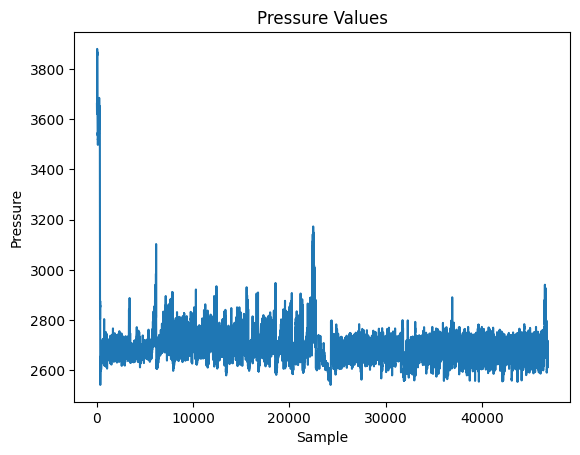

In [ ]:
plt.plot(pressure_values)
plt.xlabel('Sample')
plt.ylabel('Pressure')
plt.title('Pressure Values')
plt.show()

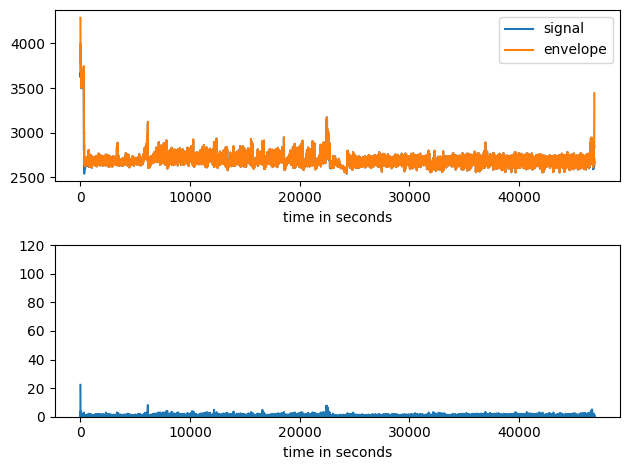

In [ ]:
from scipy.signal import hilbert
import numpy as np
import matplotlib.pyplot as plt

analytic_signal = hilbert(pressure_values)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * 1000)

fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(pressure_values, label='signal')
ax0.plot(amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1 = fig.add_subplot(212)
ax1.plot(instantaneous_frequency)
ax1.set_xlabel("time in seconds")
ax1.set_ylim(0.0, 120.0)
fig.tight_layout()
plt.show()